- Function to process Mice
- Function to perform AE
- Function to perform Kmeans SMOTE
- Function to perform all the EDA
  - Isolation forest
  - Z score
  - Non linear relationships
- Function to perform PCA

    The above all comes under the main function

    
- Function to give out Plots and other EDA after the PCA is done. It gets the PCA dataset as the input

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import IsolationForest
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import shap
import lime
from lime import lime_tabular

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from sklearn.cluster import KMeans

import missingno as msno

from fancyimpute import IterativeImputer as MICE
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import IsolationForest
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.cluster import DBSCAN
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from collections import Counter

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from imblearn.over_sampling import KMeansSMOTE
from sklearn.mixture import GaussianMixture


from xgboost import XGBClassifier
from rgf.sklearn import RGFClassifier  # Regularized Greedy Forest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from joblib import dump, load
import logging

import time


In [11]:
def preprocess_dataframe(df):

    start_time = time.time()  # Start timing

    # Replace LABEL values
    df["LABEL"] = df["LABEL"].replace({0: "Normal", 1: "Distressed"})
    df["ID"] = df["ID"].replace({0: "changed"})
    
    # Select columns from A36 to LABEL
    selected_columns = df.loc[:, 'A36':'LABEL']
    
    # Drop columns not in the selected range
    df_selected = df.drop(columns=df.columns.difference(selected_columns.columns))
    df_label = df_selected.copy()
    
    # Count the number of zeros in each row
    zeros_count = (df_label == 0).sum(axis=1)
    
    # Filter out rows with different zero thresholds
    filtered_df2L = df_label[zeros_count <= 2]
    filtered_df3L = df_label[zeros_count <= 3]
    filtered_df4L = df_label[zeros_count <= 4]
    filtered_df5L = df_label[zeros_count <= 5]
    filtered_df8L = df_label[zeros_count <= 8]
    filtered_df10L = df_label[zeros_count <= 10]
    
    # Replace 0 with NaN values in all filtered dataframes
    filtered_df2 = filtered_df2L.replace(0, np.nan)
    filtered_df3 = filtered_df3L.replace(0, np.nan)
    filtered_df4 = filtered_df4L.replace(0, np.nan)
    filtered_df5 = filtered_df5L.replace(0, np.nan)
    filtered_df8 = filtered_df8L.replace(0, np.nan)
    filtered_df10 = filtered_df10L.replace(0, np.nan)
    
    # Print info of the final dataframe with the strictest zero threshold
    # filtered_df2.drop("LABEL", axis=1).info()

    print(filtered_df2.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for preprocess_dataframe: {elapsed_time:.2f} mins")
    
    return {
        "filtered_df2": filtered_df2,
        "filtered_df3": filtered_df3,
        "filtered_df4": filtered_df4,
        "filtered_df5": filtered_df5,
        "filtered_df8": filtered_df8,
        "filtered_df10": filtered_df10,
        "filtered_df2L": filtered_df2L,
        "filtered_df3L": filtered_df3L,
        "filtered_df4L": filtered_df4L,
        "filtered_df5L": filtered_df5L,
        "filtered_df8L": filtered_df8L,
        "filtered_df10L": filtered_df10L
    }


def impute_with_mice(df, dfL):

    start_time = time.time()  # Start timing

    df = df.drop("LABEL", axis=1)
    
    # Create the MICE imputer object
    imputer = IterativeImputer(max_iter=10, random_state=0)
    
    # Fit the imputer to the data and transform it
    df_mice = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Display the first few rows of the imputed DataFrame
    print("Dataframe before MICE imputation: \n", df.head(3))
    print("DataFrame after MICE imputation:\n", df_mice.head(3))
    
    # Saving the labels back in the dataframe
    labels = dfL["LABEL"]
    print("Length of labels: ", len(labels))
    
    # Reassigning the values in LABEL column
    df_mice["LABEL"] = labels.values
    
    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60

    print(f"Time taken for impute_with_mice: {elapsed_time:.2f} mins")


    return df_mice


def impute_with_autoencoder(df, dfL):

    start_time = time.time()  # Start timing

    # To further process the numerical columns
    df = df.drop("LABEL", axis=1)
    
    
    # Fill the nan with 0 for autoencoder training
    df_replaced = df.replace(np.nan, 0)

    # Normalize data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_replaced)
    
    # Split data into train and validation sets
    X_train, X_val = train_test_split(df_scaled, test_size=0.2, random_state=42)
    
    # Define the autoencoder architecture
    input_dim = X_train.shape[1]
    encoding_dim = int(input_dim / 2)
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer='l2')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Print model summary
    autoencoder.summary()
    
    # Train the autoencoder
    history = autoencoder.fit(X_train, X_train,
                              epochs=35,
                              batch_size=32,
                              shuffle=True,
                              validation_data=(X_val, X_val))
    
    # Predict using the original df_scaled (with zeros)
    data_imputed_scaled = autoencoder.predict(df_scaled)
    
    # Inverse transform to get data_imputed_df
    data_imputed = scaler.inverse_transform(data_imputed_scaled)
    data_imputed_df = pd.DataFrame(data_imputed, columns=df.columns, index=df.index)
    
    # Saving a copy version
    df_AEimputed = df.copy()
    
    # Replace only the missing values with imputed values
    for col in df.columns:
        mask = df[col].isnull()
        df_AEimputed.loc[mask, col] = data_imputed_df.loc[mask, col]
    
    print("Original Data with Missing Values:\n", df.isnull().sum())
    print("Data after Autoencoder Imputation:\n", df_AEimputed.isnull().sum())
    
    # Reassign values of LABEL column back to the dataset
    df_AEimputed["LABEL"] = dfL["LABEL"].values

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for impute_with_autoencoder: {elapsed_time:.2f} mins")
    
    return df_AEimputed



def visualize_high_dim_data(df, n_components=2, perplexity=30, random_state=42):
    """
    Visualize high-dimensional data using t-SNE.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    n_components (int): Number of dimensions to reduce to (default 2)
    perplexity (float): Perplexity parameter for t-SNE (default 30)
    random_state (int): Random state for reproducibility (default 42)
    
    Returns:
    None (displays plot)
    """
    # Prepare the data
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols].values
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(X_scaled)
    
    # Visualize results
    plt.figure(figsize=(6, 4))
    
    # t-SNE plot
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=range(len(X)), cmap='viridis')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.colorbar(scatter, label='Data Point Index')
    
    plt.tight_layout()
    plt.show()


def reprocess_for_smote_pca(df_imputed):

    start_time = time.time()  # Start timing

    """
    Reprocess the imputed dataframe for SMOTE and PCA by replacing string values in the "LABEL" column with binary values.
    
    Parameters:
    df_imputed (pd.DataFrame): The imputed dataframe with "LABEL" column containing string values.
    
    Returns:
    pd.DataFrame: The reprocessed dataframe with binary values in the "LABEL" column.
    """
    df_reprocessed = df_imputed.copy()
    df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for reprocess_for_smote_pca: {elapsed_time:.2f} mins")
    
    return df_reprocessed


# this is to check the underlying pattern of the data - linear or non-linear
def compare_linear_non_linear_models(df, target_column='LABEL'):
    
    # Split the data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit a linear model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    linear_residuals = y_test - linear_model.predict(X_test)

    # Fit a non-linear model
    non_linear_model = RandomForestRegressor()
    non_linear_model.fit(X_train, y_train)
    non_linear_residuals = y_test - non_linear_model.predict(X_test)

    # Print MSE for both models
    linear_mse = mean_squared_error(y_test, linear_model.predict(X_test))
    non_linear_mse = mean_squared_error(y_test, non_linear_model.predict(X_test))

    print(f'Linear Model MSE: {linear_mse}')
    print(f'Non-linear Model MSE: {non_linear_mse}')

    # Plot residuals
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test, y=linear_residuals)
    plt.axhline(0, ls='--', color='r')
    plt.title('Linear Model Residuals')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=non_linear_residuals)
    plt.axhline(0, ls='--', color='r')
    plt.title('Non-linear Model Residuals')

    plt.tight_layout()
    plt.show()


def kmeans_smote_resampling(df):

    start_time = time.time()  # Start timing

    # Preprocessing
    X = df.drop(columns=["LABEL"])
    y = df["LABEL"]
    
    # Separate the classes
    X_minority = X[y == 1]
    X_majority = X[y == 0]
    
    # Visualize the minority class
    plt.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Minority Class Distribution")
    plt.legend()
    plt.show()
    
    # Define the KMeans estimator with a higher number of clusters and set n_init explicitly
    kmeans_estimator = KMeans(n_clusters=5, random_state=42, n_init=10)
    
    # Apply KMeans-SMOTE to the entire dataset with adjusted parameters
    kmeans_smote = KMeansSMOTE(kmeans_estimator=kmeans_estimator, cluster_balance_threshold=0.01, random_state=42)
    X_resampled, y_resampled = kmeans_smote.fit_resample(X, y)
    
    # Verify the balance of the new dataset
    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))
    
    # Convert X_resampled and y_resampled to DataFrames
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)  # Assuming X has column names
    y_resampled_df = pd.DataFrame(y_resampled, columns=['LABEL'])  # Adjust column name as needed
    
    # Concatenate X_resampled_df and y_resampled_df along columns axis
    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)
    
    # Save resampled DataFrame to Excel
    # resampled_df.to_excel('df_autoencoder_KM_SMOTE.xlsx', index=False)
    
    df_processed = resampled_df.copy()
    
    # Visualize the resampled dataset
    plt.scatter(X_resampled[y_resampled == 0].iloc[:, 0], X_resampled[y_resampled == 0].iloc[:, 1], label='Majority Class', alpha=0.6)
    plt.scatter(X_resampled[y_resampled == 1].iloc[:, 0], X_resampled[y_resampled == 1].iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Resampled Dataset Distribution")
    plt.legend()
    plt.show()

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for kmeans_smote_resampling: {elapsed_time:.2f} mins")
    
    return df_processed



def process_pca(df):

    start_time = time.time()  # Start timing

    def compute_pca(df, columns, n_components=2):
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df[columns])
        
        # Compute PCA
        pca = PCA(n_components=n_components)
        pca_data = pca.fit_transform(scaled_data)
        
        # Create a DataFrame with the PCA results
        pca_columns = [f'PC{i+1}' for i in range(n_components)]
        pca_df = pd.DataFrame(pca_data, columns=pca_columns)
        
        return pca_df

    def pca_transformed_df(df, ratio_categories, n_components=2):
        pca_results = []

        for category, columns in ratio_categories.items():
            pca_df = compute_pca(df, columns, n_components)
            pca_df = pca_df.add_prefix(f'{category}_')
            pca_results.append(pca_df)

        combined_pca_df = pd.concat(pca_results, axis=1)
        return combined_pca_df

    # Define your ratio categories and their respective columns
    ratio_categories = {
        "Liquidity_and_Coverage_Ratios" :  ['A36', 'A37', 'A38', 'A44', 'A41', 'A43'],
        "Leverage_Ratios" : ['A39', 'A40', 'A42', 'A48', 'A71', 'A72', 'A73'],
        "Activity_Ratios" :  ['A45', 'A46', 'A47', 'A50','A53', 'A54', 'A56'],
        "Profitability_Ratios" :  ['A49', 'A57', 'A58', 'A59', 'A61', 'A62'],
        "Cost_and_Expense_Ratios" :  ['A63', 'A64', 'A65', 'A66'],
        "Cash_Flow_Ratios" : ['A67', 'A68', 'A69', 'A70'],
        "Growth_Ratios" : ['A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81'],
        "Per_Share_Ratios" :  ['A82', 'A83', 'A84']
    }

    # Compute PCA and get the combined DataFrame
    combined_pca_df = pca_transformed_df(df, ratio_categories, n_components=2)

    # Add the LABEL column back to the combined PCA DataFrame
    combined_pca_df["LABEL"] = df["LABEL"]

    # Save the combined PCA DataFrame to a CSV file (optional)
    # combined_pca_df.to_csv('combined_pca_ratios.csv', index=False)

    # Display the first few rows of the combined PCA DataFrame
    print(combined_pca_df.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for process_pca: {elapsed_time:.2f} mins")

    return combined_pca_df


# this is to check the underlying pattern of the data - linear or non-linear
def compare_linear_non_linear_models(df, target_column='LABEL'):
    

    df_patterns = df.copy()
    df_patterns["LABEL"] = df_patterns["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)

    # Split the data into features and target
    X = df_patterns.drop(columns=[target_column])
    y = df_patterns[target_column]

    # Calculate Pearson and Spearman correlations
    pearson_corr = df_patterns.corr(method='pearson')[target_column].drop(target_column)
    spearman_corr = df_patterns.corr(method='spearman')[target_column].drop(target_column)
    
    # Combine correlations into a DataFrame
    corr_df = pd.DataFrame({
        'Pearson': pearson_corr,
        'Spearman': spearman_corr
    }).sort_values('Spearman', key=abs, ascending=False)
    
    # Calculate the difference between Pearson and Spearman
    corr_df['Difference'] = corr_df['Pearson'] - corr_df['Spearman']
    
    # Print correlations
    print("Pearson and Spearman Correlations:")
    print(corr_df)


def comprehensive_analysis(df):
    # Create a copy of the dataframe
    df_analysis = df.copy()
    
    # Convert LABEL to numeric
    df_analysis["LABEL"] = df_analysis["LABEL"].replace({"Normal": 0, "Distressed": 1})
    
    # 1. Basic statistics and missing values
    print("Basic Statistics:")
    print(df_analysis.describe())
    print("\nMissing Values:")
    print(df_analysis.isnull().sum())
    
    # 2. Correlation analysis
    corr_matrix = df_analysis.corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # 3. Identify highly correlated features
    high_corr = np.where(np.abs(corr_matrix) > 0.8)
    high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                       for x, y in zip(*high_corr) if x != y and x < y]
    print("\nHighly correlated feature pairs:")
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {corr_matrix.loc[pair[0], pair[1]]:.2f}")
    
    # 4. Outlier detection using multiple methods
    # Prepare data for outlier detection (exclude non-numeric columns)
    numeric_cols = df_analysis.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_analysis[numeric_cols])
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers_iso = iso_forest.fit_predict(scaled_data)
    
    # Z-score
    z_scores = np.abs(stats.zscore(df_analysis[numeric_cols]))
    outliers_z = np.where(z_scores > 3)
    
    print(f"\nNumber of potential outliers (Isolation Forest): {sum(outliers_iso == -1)}")
    print(f"Number of potential outliers (Z-score > 3): {len(outliers_z[0])}")
    
    # 5. Skewness and Kurtosis analysis
    skewness = df_analysis[numeric_cols].skew()
    kurtosis = df_analysis[numeric_cols].kurtosis()
    print("\nSkewness of features:")
    print(skewness)
    print("\nKurtosis of features:")
    print(kurtosis)




def main(df):
        
        print("Executing the main function.")
        datasets = preprocess_dataframe(df)

        print("Preprocessed Datasets.")

        print("Results on comparing the data for pattern check before preprocessing")
        compare_linear_non_linear_models(datasets["filtered_df3L"])

        print("Comprehensive analysis on primary dataset prior to processing:")
        comprehensive_analysis(datasets["filtered_df3L"])


        print(" ------------  TSNE before the processing -------------- ")
        # to know the pattern of the underlying data before and after imputation
        visualize_high_dim_data(datasets["filtered_df3L"])


        print("_______________________________________________________________________________")
        print("*******************************************************************************")
        print("                        Proceedings for MICE:")
        print("_______________________________________________________________________________")
        print("*******************************************************************************")

        start_time = time.time()  # Start timing

        # Impute null values using MICES
        mice_imputed_df = impute_with_mice(datasets["filtered_df3"], datasets["filtered_df3L"])

        print(" ------------  TSNE after MICE the processing -------------- ")

        # to know the pattern of the underlying data before and after imputation
        visualize_high_dim_data(mice_imputed_df)
        
        # Reprocess the data for SMOTE and PCA
        df_mice_reprocessed = reprocess_for_smote_pca(mice_imputed_df)
        
        # Apply SMOTE resampling
        df_mice_resampled = kmeans_smote_resampling(df_mice_reprocessed)
        
        # Process PCA
        pca_df_mice = process_pca(df_mice_resampled)

        print("Comprehensive analysis on MICE processed dataset :")
        comprehensive_analysis(pca_df_mice)

        print("Results on comparing the data for pattern check after preprocessing with MICE")
        compare_linear_non_linear_models(pca_df_mice)

        end_time = time.time()  # End timing
        elapsed_time = (end_time - start_time) / 60
        
        print("_______________________________________________________________________________")
        print(f" Total time taken: {elapsed_time:.2f} mins")

        print(" ")
        print(" ")
        print(" ")
        
        print("_______________________________________________________________________________")
        print("*******************************************************************************")
        print("                        Proceedings for Autoencoder:")
        print("_______________________________________________________________________________")
        print("*******************************************************************************")

        start_time = time.time()  # Start timing

        # Impute null values using Autoencoders
        ae_imputed_df = impute_with_autoencoder(datasets["filtered_df3"], datasets["filtered_df3L"])


        print(" ------------  TSNE after Autoencoder (AE) the processing -------------- ")

        # to know the pattern of the underlying data before and after imputation
        visualize_high_dim_data(ae_imputed_df)

        # Reprocess the data for SMOTE and PCA
        df_autoencoder_reprocessed = reprocess_for_smote_pca(ae_imputed_df)

        # Apply SMOTE resampling
        df_autoencoder_resampled = kmeans_smote_resampling(df_autoencoder_reprocessed)

        # Process PCA
        pca_df_autoencoder = process_pca(df_autoencoder_resampled)

        print("Comprehensive analysis on Autoencoder processed dataset :")
        comprehensive_analysis(pca_df_autoencoder)

        print("Results on comparing the data for pattern check after preprocessing with Autoencoders")
        compare_linear_non_linear_models(pca_df_autoencoder)

        end_time = time.time()  # End timing
        elapsed_time = (end_time - start_time) / 60
        
        print("_______________________________________________________________________________")
        print(f" Total time taken: {elapsed_time:.2f} mins")

        #pca_df_mice.to_excel("KMSMOTE_MICE_3_PCA.xlsx", index=False)
        #pca_df_autoencoder.to_excel("KMSMOTE_AE_3_PCA.xlsx", index=False)


In [12]:
df = pd.read_excel("C:\\Users\\dev\\Desktop\\financial distress\\financial_distress_python.xlsx")

Executing the main function.
         A36       A37       A38       A39       A40       A41       A42  \
80  2.523392  2.523302  1.014784  1.595410  0.286062  0.920518  2.495750   
81  3.615532  3.615399  1.436531  0.036077  0.265880  0.948497  2.761092   
82  2.285354  2.285278  0.364360 -0.357243  0.272066  0.922328  2.675580   

         A43       A44       A45  ...       A76       A77       A78       A79  \
80  0.400940  3.495750  0.015180  ...  0.017401  6.198123  6.858067 -2.986409   
81  0.362409  3.761092  0.018626  ... -0.019641 -0.786114 -0.768645 -0.964392   
82  0.373985  3.675580  0.019985  ...  0.007605  8.771772  9.772075 -1.335116   

         A80       A81       A82       A83       A84   LABEL  
80 -6.802062 -1.236756  0.002919 -0.021170 -0.013083  Normal  
81 -0.403760 -3.244087  0.000742 -0.019156 -0.005283  Normal  
82 -0.519225 -0.166025  0.003555 -0.023129 -0.013871  Normal  

[3 rows x 46 columns]
Time taken for preprocess_dataframe: 0.00 mins
Preprocessed Datase

C:\Users\dev\AppData\Local\Temp\ipykernel_15808\2013415342.py:386: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_patterns["LABEL"] = df_patterns["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)
C:\Users\dev\AppData\Local\Temp\ipykernel_15808\2013415342.py:415: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_analysis["LABEL"] = df_analysis["LABEL"].replace({"Normal": 0, "Distressed": 1})


                A36           A37           A38            A39           A40  \
count  10329.000000  10329.000000  10329.000000   10329.000000  10329.000000   
mean       2.022856      1.756372      0.626768      39.336738      0.908218   
std        3.623821      3.426218      2.551893    3776.481902      5.158135   
min        0.000495      0.000495     -0.000440  -45959.500000      0.006286   
25%        0.773622      0.591516      0.023594       0.000000      0.361950   
50%        1.289137      1.074761      0.137065       1.188972      0.551843   
75%        2.101597      1.765861      0.461638       3.565240      0.746480   
max      155.666667    155.666667    131.745098  376847.000000    231.132597   

                A41           A42           A43           A44           A45  \
count  10329.000000  10329.000000  10329.000000  10329.000000  10329.000000   
mean       0.524632      1.600129     -6.803915      2.600129      0.333257   
std        2.426162      3.781777    648.1

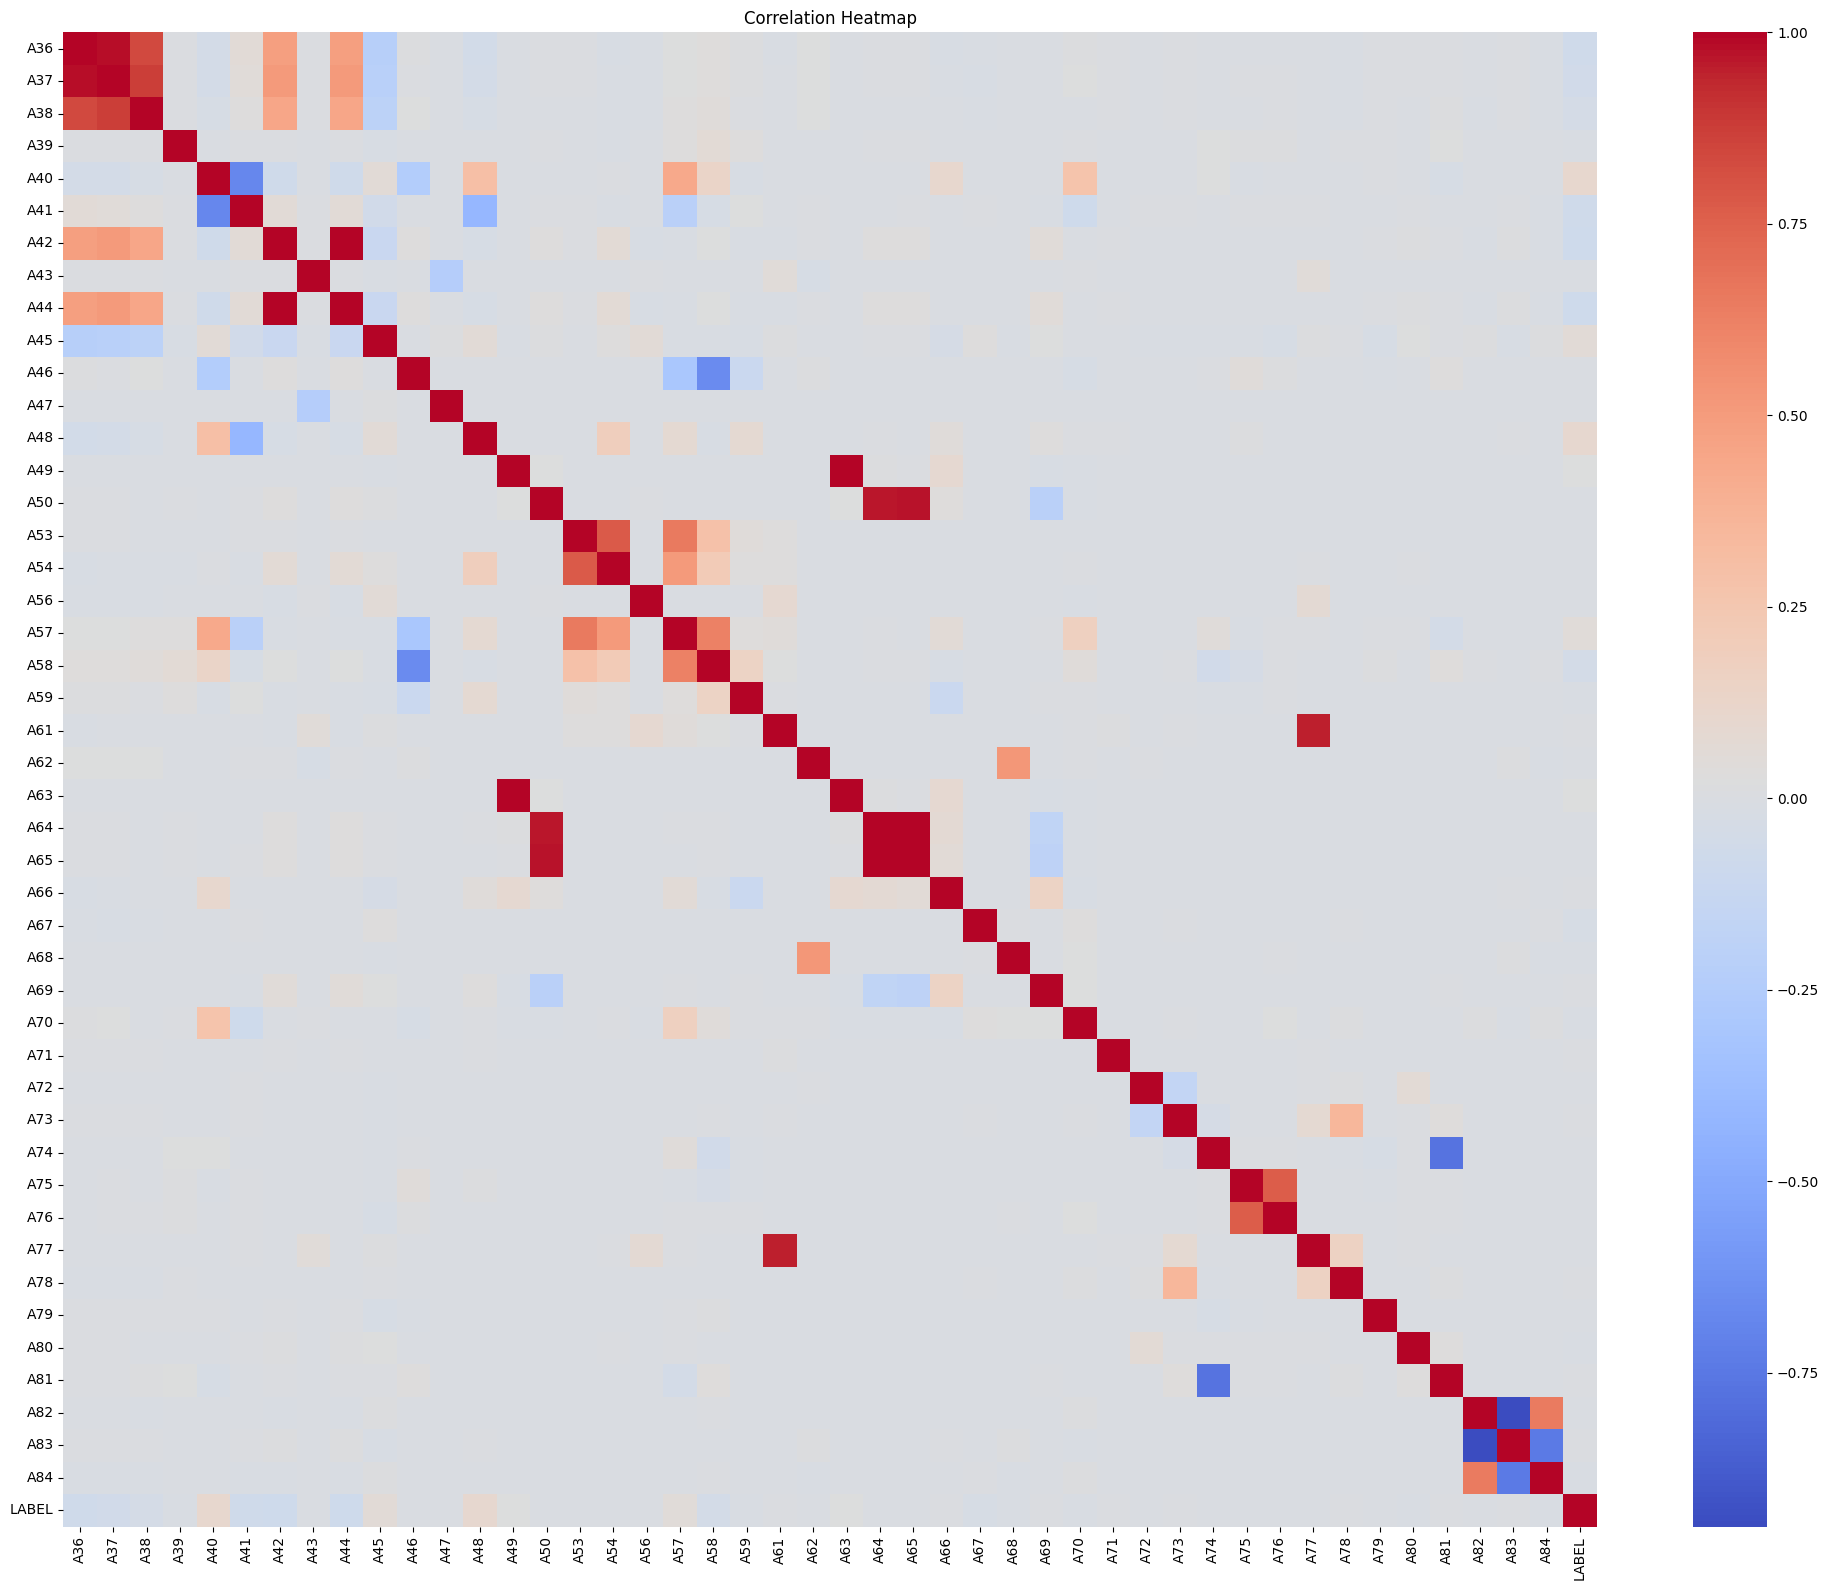


Highly correlated feature pairs:
A36 - A37: 0.98
A36 - A38: 0.83
A37 - A38: 0.87
A42 - A44: 1.00
A49 - A63: 1.00
A50 - A64: 0.96
A50 - A65: 0.97
A61 - A77: 0.95
A64 - A65: 1.00
A82 - A83: -0.95

Number of potential outliers (Isolation Forest): 1033
Number of potential outliers (Z-score > 3): 1804

Skewness of features:
A36       12.724075
A37       14.052905
A38       19.828282
A39       96.000040
A40       30.292567
A41      -42.240885
A42       15.971232
A43      -91.833629
A44       15.971232
A45        0.626105
A46      -74.995661
A47       96.307699
A48       40.801647
A49       87.686930
A50       93.168928
A53      100.875122
A54       63.108119
A56       72.204154
A57       44.201515
A58       51.840519
A59      -14.798890
A61       95.066931
A62       13.753572
A63       87.678609
A64      100.088898
A65       99.823600
A66       31.650304
A67       14.858733
A68       85.960042
A69       28.500928
A70       10.059827
A71      -71.978869
A72       55.311437
A73       -5.67981

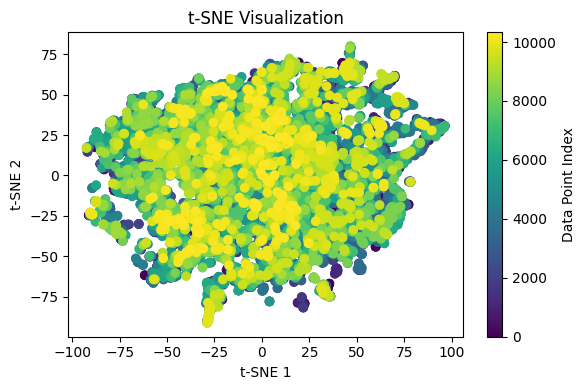

_______________________________________________________________________________
*******************************************************************************
                        Proceedings for MICE:
_______________________________________________________________________________
*******************************************************************************
Dataframe before MICE imputation: 
          A36       A37       A38       A39       A40       A41       A42  \
80  2.523392  2.523302  1.014784  1.595410  0.286062  0.920518  2.495750   
81  3.615532  3.615399  1.436531  0.036077  0.265880  0.948497  2.761092   
82  2.285354  2.285278  0.364360 -0.357243  0.272066  0.922328  2.675580   

         A43       A44       A45  ...       A75       A76       A77       A78  \
80  0.400940  3.495750  0.015180  ...  2.024763  0.017401  6.198123  6.858067   
81  0.362409  3.761092  0.018626  ...  1.975489 -0.019641 -0.786114 -0.768645   
82  0.373985  3.675580  0.019985  ...  2.011178  0

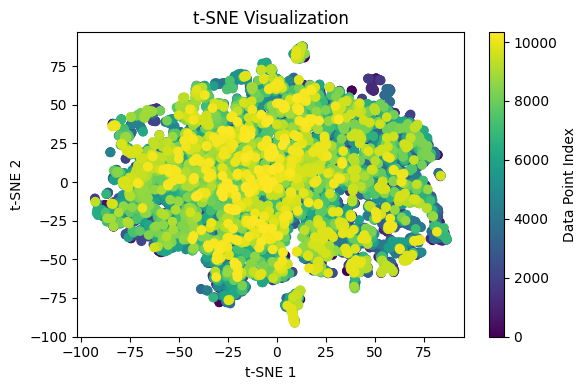

Time taken for reprocess_for_smote_pca: 0.00 mins


C:\Users\dev\AppData\Local\Temp\ipykernel_15808\2013415342.py:211: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


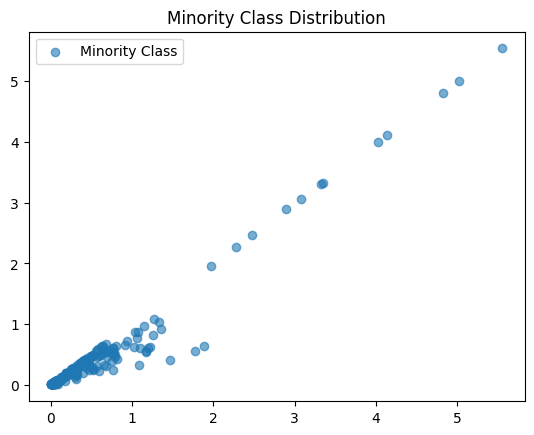

Original class distribution: Counter({0: 10062, 1: 267})
Resampled class distribution: Counter({1: 10063, 0: 10062})


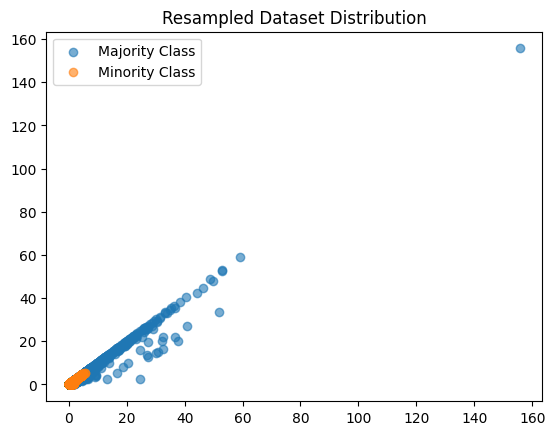

Time taken for kmeans_smote_resampling: 0.01 mins
   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           1.044059                           0.003853   
1                           1.638262                           0.003264   
2                           0.794693                           0.003885   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.667224             0.015571            -0.079080   
1            -0.714215             0.016845            -0.074370   
2            -0.697014             0.007657            -0.074604   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0            -1.156702                  0.182547                 -0.106909   
1            -1.146165                  0.150074                 -0.121664   
2            -1.141965                  0.138172                 -0.106356   

   Cost_and_Expense_Ratios_PC1  Cost_and_Expense_Ratios_PC2  \


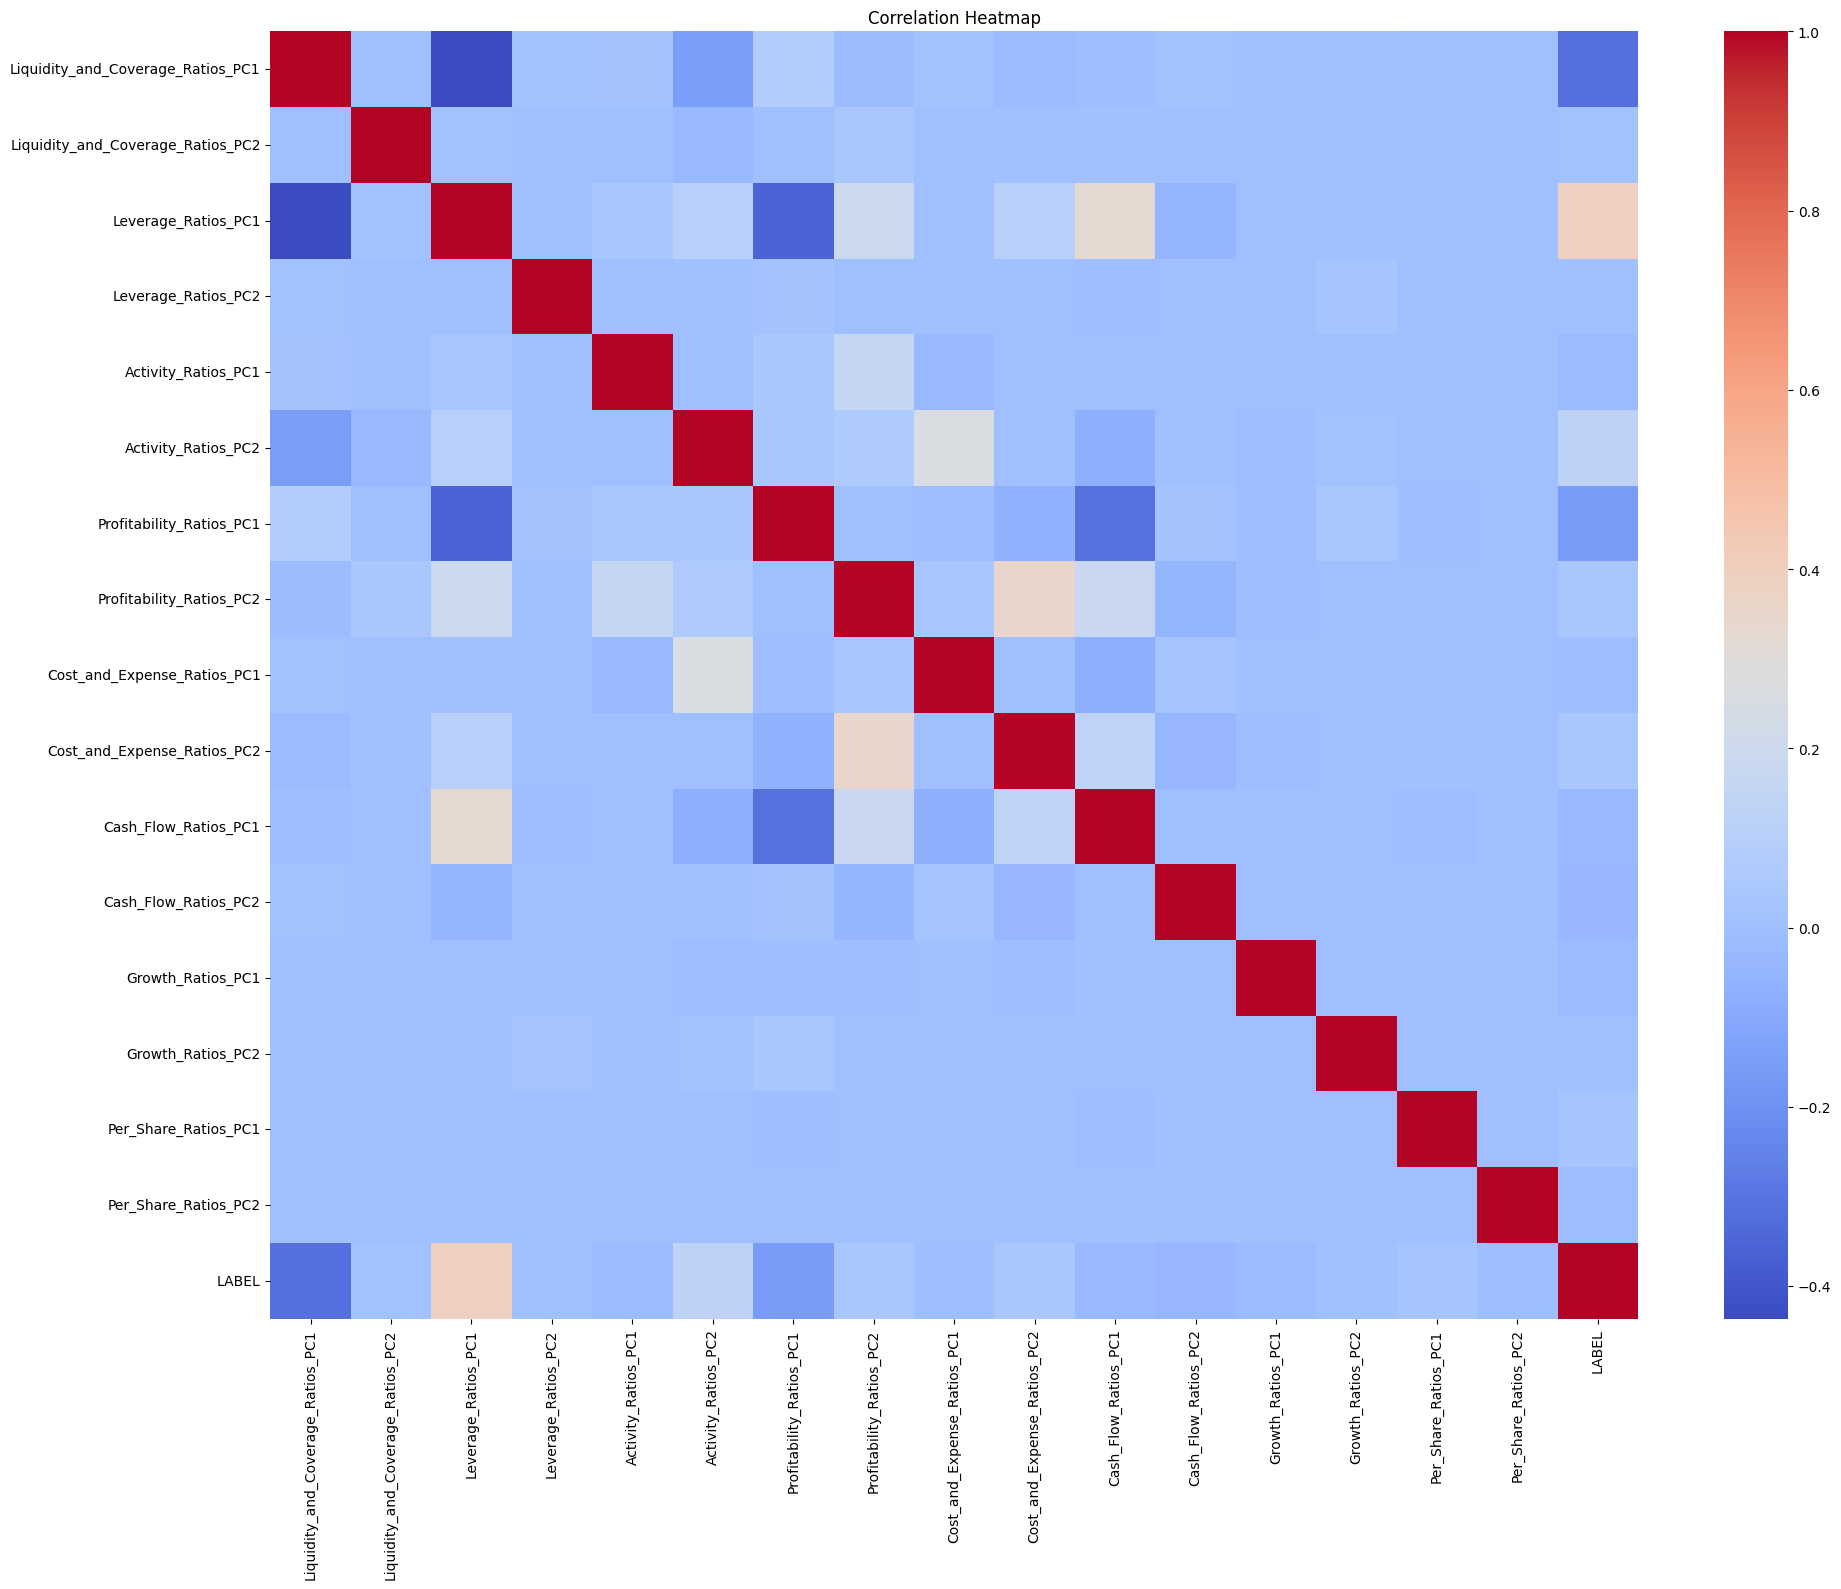


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2013
Number of potential outliers (Z-score > 3): 1461

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     20.965352
Liquidity_and_Coverage_Ratios_PC2   -126.707336
Leverage_Ratios_PC1                    6.765075
Leverage_Ratios_PC2                  -45.339471
Activity_Ratios_PC1                   89.479799
Activity_Ratios_PC2                   32.946907
Profitability_Ratios_PC1               0.184323
Profitability_Ratios_PC2              62.990896
Cost_and_Expense_Ratios_PC1          136.238073
Cost_and_Expense_Ratios_PC2           23.286295
Cash_Flow_Ratios_PC1                  13.745306
Cash_Flow_Ratios_PC2                  33.851644
Growth_Ratios_PC1                     73.846641
Growth_Ratios_PC2                   -115.774302
Per_Share_Ratios_PC1                 -45.792300
Per_Share_Ratios_PC2                   9.983996
LABEL                                 -0.000099
dtype: float64

Kurtosi

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 45)             │         1,035 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,047 (8.00 KB)

 Trainable params: 2,047 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - loss: 1.2493 - val_loss: 0.8344
Epoch 2/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 1.1121 - val_loss: 0.7419
Epoch 3/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.8145 - val_loss: 0.6874
Epoch 4/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.7294 - val_loss: 0.6493
Epoch 5/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 0.6113 - val_loss: 0.6282
Epoch 6/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.6494 - val_loss: 0.6003
Epoch 7/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 0.5014 - val_loss: 0.5887
Epoch 8/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.4554 - val_loss: 0.5790
Epoch 9/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.4927 - val_loss: 0.5712
Epoch 10/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 0.3796 - val_loss: 0.5654
Epoch 11/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 0.4220 - val_loss: 0.5651
Epoch 12/35
351/351 ━━━━━━━━━━

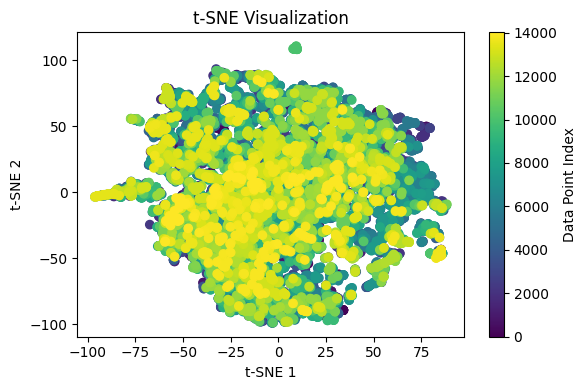

Time taken for reprocess_for_smote_pca: 0.00 mins


C:\Users\dev\AppData\Local\Temp\ipykernel_15808\2013415342.py:211: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


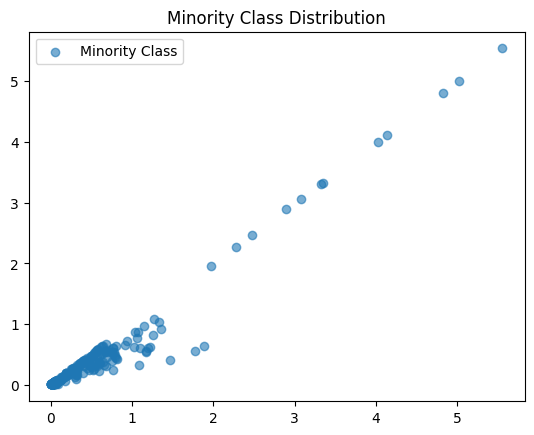

Original class distribution: Counter({0: 13708, 1: 307})
Resampled class distribution: Counter({1: 13709, 0: 13708})


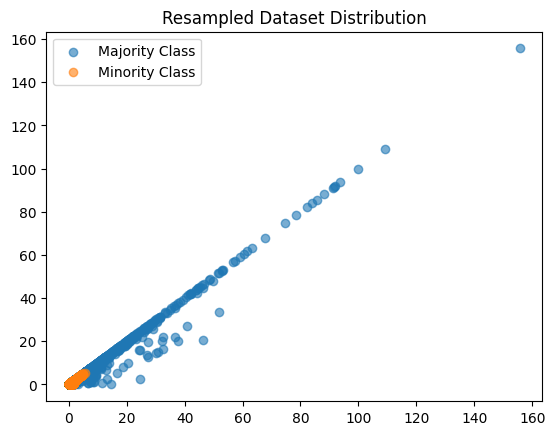

Time taken for kmeans_smote_resampling: 0.01 mins
   Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
0                           0.918002                           0.476153   
1                           1.422593                           0.401676   
2                           0.676775                           0.557200   

   Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
0            -0.649573            -0.001519            -1.058032   
1            -0.698481             0.000612            -1.046336   
2            -0.681170             0.001651            -1.041719   

   Activity_Ratios_PC2  Profitability_Ratios_PC1  Profitability_Ratios_PC2  \
0             0.117308                 -0.009511                 -0.017059   
1             0.147990                 -0.011769                 -0.015806   
2             0.159763                 -0.009821                 -0.015789   

   Cost_and_Expense_Ratios_PC1  Cost_and_Expense_Ratios_PC2  \


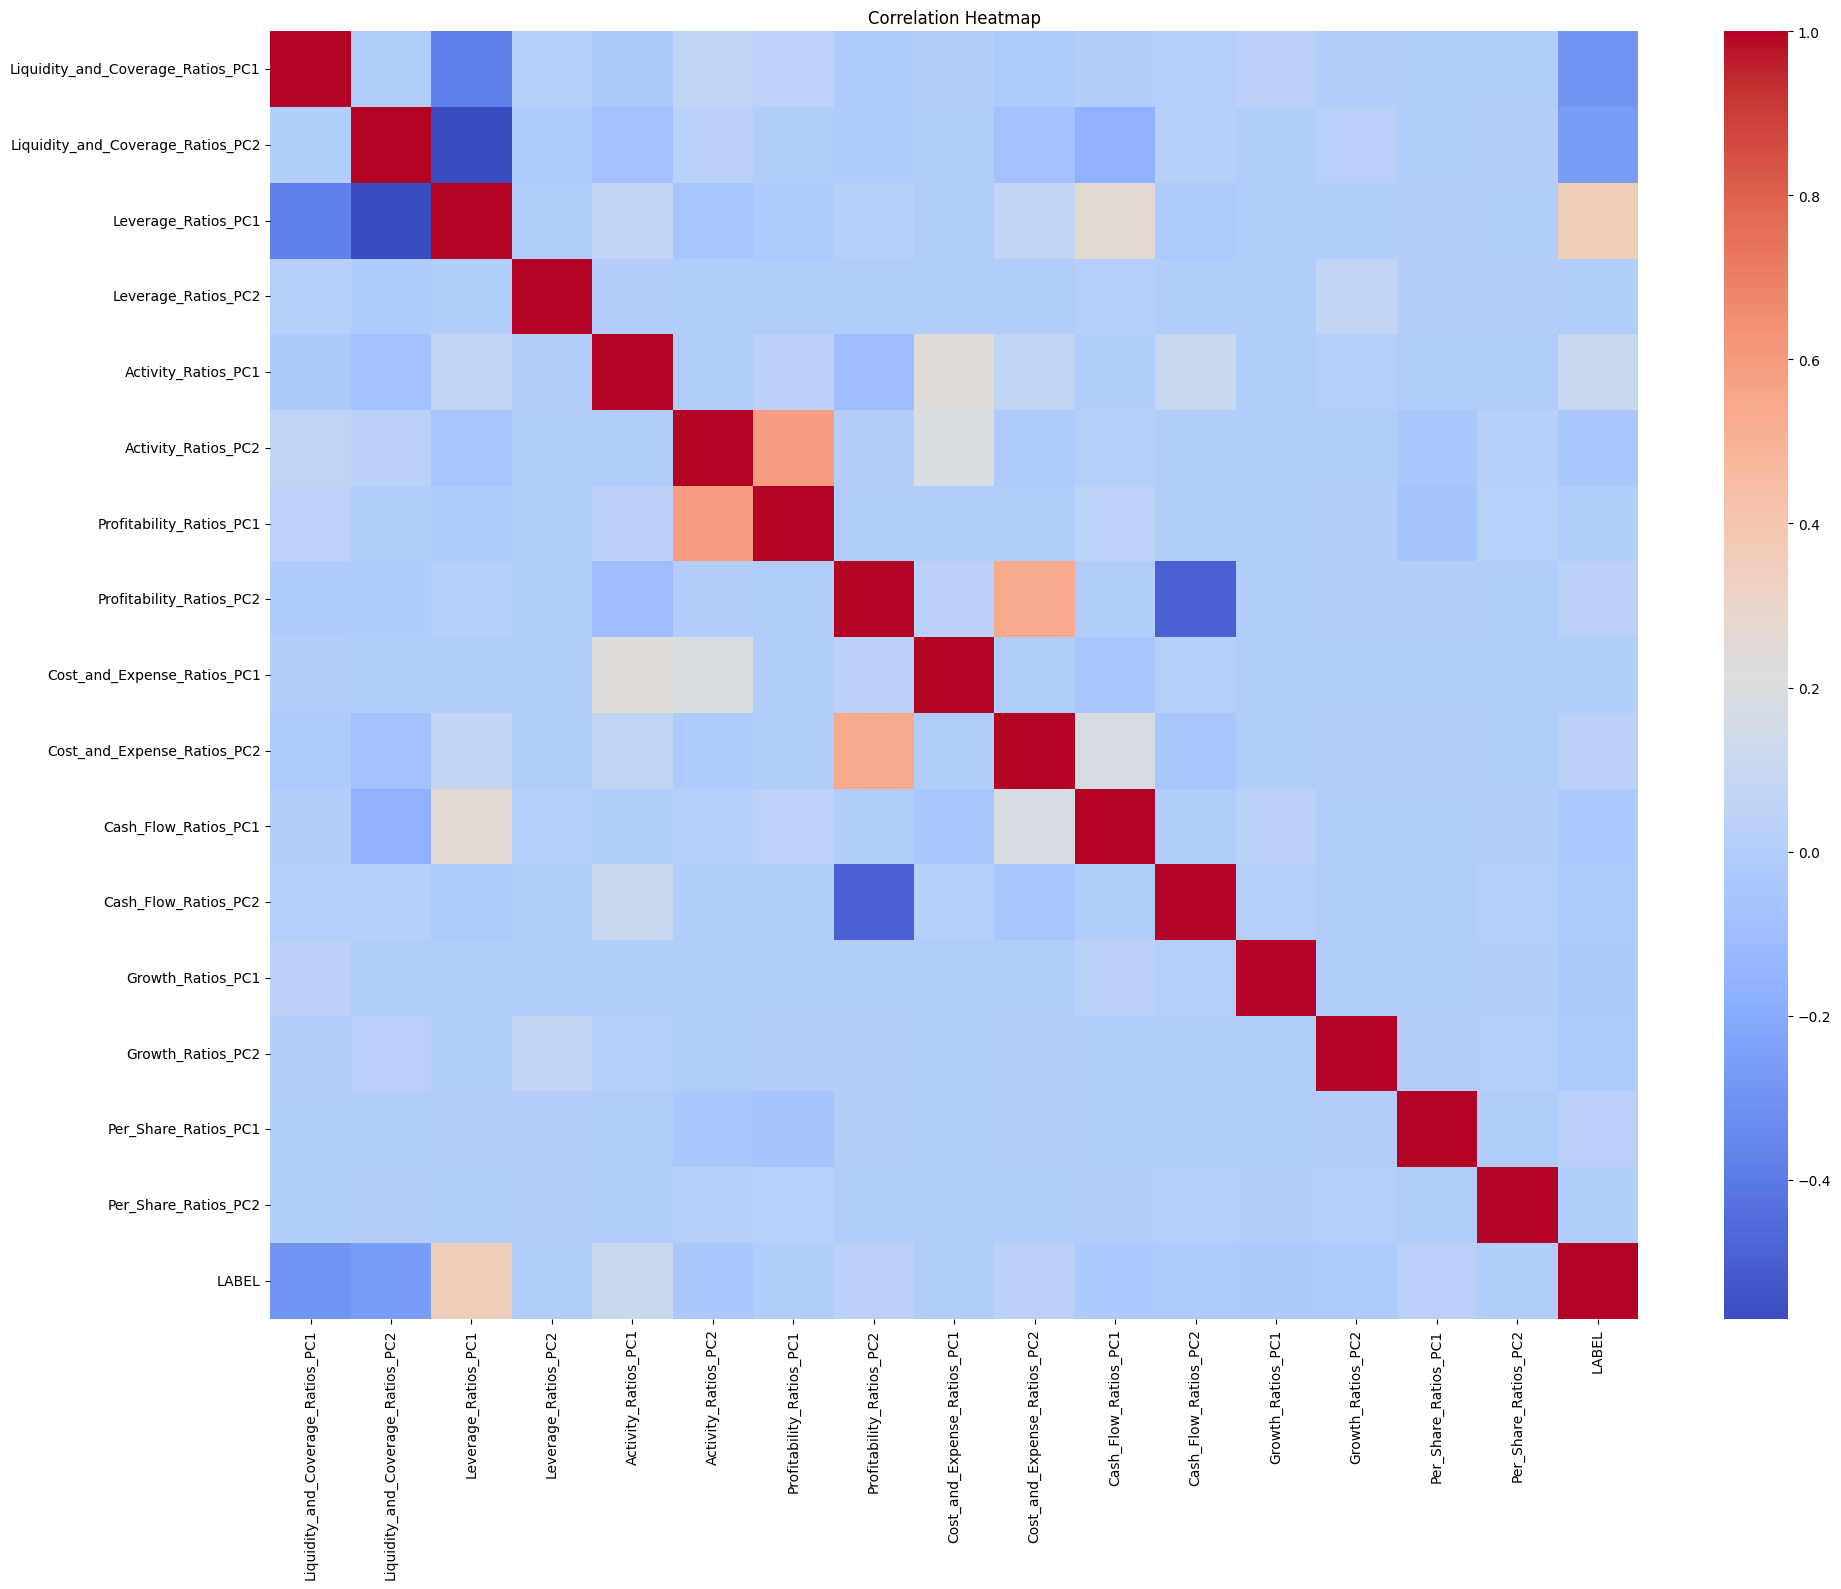


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2741
Number of potential outliers (Z-score > 3): 1970

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     17.536333
Liquidity_and_Coverage_Ratios_PC2    -17.272990
Leverage_Ratios_PC1                    9.808742
Leverage_Ratios_PC2                   57.722936
Activity_Ratios_PC1                    8.374419
Activity_Ratios_PC2                   84.270914
Profitability_Ratios_PC1             158.047513
Profitability_Ratios_PC2             -25.492935
Cost_and_Expense_Ratios_PC1          157.557322
Cost_and_Expense_Ratios_PC2           29.905553
Cash_Flow_Ratios_PC1                  18.845452
Cash_Flow_Ratios_PC2                  43.979830
Growth_Ratios_PC1                     64.320016
Growth_Ratios_PC2                     85.458423
Per_Share_Ratios_PC1                 -53.099721
Per_Share_Ratios_PC2                  11.490548
LABEL                                 -0.000073
dtype: float64

Kurtosi

In [13]:
main(df)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


def visualize_high_dim_data(df, n_components=4, perplexity=30, n_neighbors=15, min_dist=0.1, random_state=42):
    """
    Visualize high-dimensional data using t-SNE and UMAP with 4 components.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    n_components (int): Number of dimensions to reduce to (default 4)
    perplexity (float): Perplexity parameter for t-SNE (default 30)
    n_neighbors (int): Number of neighbors for UMAP (default 15)
    min_dist (float): Minimum distance parameter for UMAP (default 0.1)
    random_state (int): Random state for reproducibility (default 42)
    
    Returns:
    None (displays plots)
    """
    # Prepare the data
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols].values
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state, n_iter=1000, n_iter_without_progress=150)
    tsne_results = tsne.fit_transform(X_scaled)
    
    # Perform UMAP
    umap_model = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    umap_results = umap_model.fit_transform(X_scaled)
    
    # Create a figure with 4 subplots (2 rows, 2 columns)
    fig = plt.figure(figsize=(20, 20))
    
    # t-SNE plots
    ax1 = fig.add_subplot(221, projection='3d')
    scatter1 = ax1.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=tsne_results[:, 3], cmap='viridis')
    ax1.set_title('t-SNE Visualization (Components 1-3)')
    ax1.set_xlabel('t-SNE 1')
    ax1.set_ylabel('t-SNE 2')
    ax1.set_zlabel('t-SNE 3')
    plt.colorbar(scatter1, ax=ax1, label='t-SNE 4')

    ax2 = fig.add_subplot(222)
    scatter2 = ax2.scatter(tsne_results[:, 0], tsne_results[:, 1], c=tsne_results[:, 2], cmap='viridis')
    ax2.set_title('t-SNE Visualization (Components 1-2)')
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    plt.colorbar(scatter2, ax=ax2, label='t-SNE 3')
    
    # UMAP plots
    ax3 = fig.add_subplot(223, projection='3d')
    scatter3 = ax3.scatter(umap_results[:, 0], umap_results[:, 1], umap_results[:, 2], c=umap_results[:, 3], cmap='viridis')
    ax3.set_title('UMAP Visualization (Components 1-3)')
    ax3.set_xlabel('UMAP 1')
    ax3.set_ylabel('UMAP 2')
    ax3.set_zlabel('UMAP 3')
    plt.colorbar(scatter3, ax=ax3, label='UMAP 4')

    ax4 = fig.add_subplot(224)
    scatter4 = ax4.scatter(umap_results[:, 0], umap_results[:, 1], c=umap_results[:, 2], cmap='viridis')
    ax4.set_title('UMAP Visualization (Components 1-2)')
    ax4.set_xlabel('UMAP 1')
    ax4.set_ylabel('UMAP 2')
    plt.colorbar(scatter4, ax=ax4, label='UMAP 3')
    
    plt.tight_layout()
    plt.show()

    # Print explained variance for t-SNE (not typically used, but can be informative)
    tsne_var = np.var(tsne_results, axis=0)
    tsne_var_ratio = tsne_var / np.sum(tsne_var)
    print("t-SNE explained variance ratio:", tsne_var_ratio)

    # Print some statistics about the UMAP embedding
    umap_var = np.var(umap_results, axis=0)
    umap_var_ratio = umap_var / np.sum(umap_var)
    print("UMAP variance ratio:", umap_var_ratio)